In [ ]:
!pip install tqdm
!pip install openpyxl
!pip install yfinance

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import glob
from datetime import datetime
from google.colab import drive
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
drive.mount('/content/drive')

# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

Mounted at /content/drive


#### LGB+feature engineering

In [ ]:
def ts_sum(df, window=10):
    return df.rolling(window).sum()

def sma(df, window=10):
    return df.rolling(window).mean()

def ts_min(df, window=10):
    return df.rolling(window).min()

def ts_median(df, window=10):
    return df.rolling(window).median()

def ts_max(df, window=10):
    return df.rolling(window).max()

def delta(df, period=1):
    return df.diff(period)

def delay(df, period=1):
    return df.shift(period)

def rank(df):
    return df.rank(axis=1, pct=True)

def ts_argmax(df, window=10):
    return df.rolling(window).apply(np.argmax) + 1



In [ ]:

class AlphaLib(object):
    def __init__(self, daily_info):
        self.open = daily_info['open']
        self.high = daily_info['high']
        self.low = daily_info['low']
        self.close = daily_info['close']
        self.vwap = daily_info['vwap']
        self.volume = daily_info['volume']
        self.amount = daily_info['amount']
        self.SDG_Mean = daily_info['SDG_Mean']
        self.STS_Mean = daily_info['STS_Mean']
        self.LTS_Mean = daily_info['LTS_Mean']
        self.SDG_STD_Mean = daily_info['SDG_STD_Mean']

    def calcu_alpha(self):
        alpha_dict={}
        alpha_dict['alpha01']=((self.close/sma(self.close,10)-1)*self.amount).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha02']=sma(self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha06']=sma((self.close/sma(self.close, 5)-1)*self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha07']=ts_max((self.close/sma(self.close, 15)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha08']=ts_min((self.close/ts_max(self.close, 60)-1)*self.amount,10).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha09']=ts_max((self.close/ts_min(self.close, 60)-1)*self.amount,50).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha10']=ts_max((self.close/ts_min(self.close, 20)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha12']=ts_max((ts_max(self.high,30)/ts_min(self.low, 30)-1)*self.amount,20).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha13']=ts_max(self.high-self.low, 30)/ts_min(self.close+self.open, 30)
        alpha_dict['alpha14']=ts_sum(self.amount*(self.close-self.open), 5)
        alpha_dict['alpha15']=ts_max(self.amount*(self.high-self.low), 15)
        alpha_dict['alpha16']=ts_sum(self.amount*(self.close-self.vwap), 5)
        alpha_dict['alpha17']=ts_min(self.amount*(self.low-self.vwap), 15)
        alpha_dict['alpha18']=ts_min(self.amount*(self.open-self.vwap), 15)
        alpha_dict['alpha19']=ts_min(self.amount*(self.open-self.low), 10)
        alpha_dict['alpha20']=ts_max(self.amount*(self.close-self.low), 10)
        alpha_dict['alpha21']=ts_median(self.amount,15)/ts_sum(self.amount,15)
        alpha_dict['alpha23']=ts_max(self.amount,15)/ts_min(self.amount,10)
        alpha_dict['alpha24']=ts_sum(self.amount.div(self.amount.sum(1),axis=0),5)
        alpha_dict['alpha28']=(ts_max(self.close,5)/delay(self.close,5))*ts_min(self.close,5)/self.close

        tmp2=abs((self.close-self.open)/(self.high-self.low+0.01))
        alpha_dict['alpha29']=ts_max(tmp2,6)/ts_min(tmp2,6)
        alpha_dict['alpha30']=tmp2/delay(tmp2,4)

        tmp3=abs((self.low-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha31']=ts_max(tmp3,4)/ts_min(tmp3,4)

        tmp4=abs((self.high-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha32']=ts_max(tmp4,2)/ts_min(tmp4,2)

        alpha_dict['alpha_w_005'] = (rank((self.open - (ts_sum(self.vwap, 10) / 10))) * (-1 * abs(rank((self.close - self.vwap)))))
        # alpha_dict['alpha_pe']= -1*daily_info['pe_ttm']
        # alpha_dict['alpha_total_mv']= daily_info['total_mv']
        # alpha_dict['alpha_pb']= -1*daily_info['pb']
        # alpha_dict['alpha_turnover_rate']= daily_info['turnover_rate']
        # alpha_dict['alpha_volume_ratio']= daily_info['volume_ratio']
        alpha_dict['alpha_vwap']= daily_info['vwap']
        # alpha_dict['alpha_dv_ttm']= -1*daily_info['dv_ttm']
        alpha_dict['alpha33'] = (self.SDG_Mean + self.STS_Mean + self.LTS_Mean) / 3
        alpha_dict['alpha34'] = (self.SDG_Mean - sma(self.SDG_Mean)) / self.SDG_STD_Mean
        return alpha_dict


##### build training set

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/alpha_python_202505/alpha_python_202505/data/merge_SDG_price_497_companies.csv')
# df.head()
df.Timestamp = pd.to_datetime(df.Timestamp)
df.set_index('Timestamp', inplace=True)
# percentage change
df['Price_change'] = (df.groupby('Ticker')['Close'].transform(lambda x: x.pct_change().shift(-1)))*100
df.head()

,Ticker,ISIN,Company_Name,GICS Sector,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,...,SDG_16_News_Volume,SDG_17_News_Volume,SDG_News_Volume_Mean,Close,High,Low,Open,Volume,Amount,Price_change
Timestamp,,,,,,,,,,,,,,,,,,,,,
2013-04-01,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,0.027248,...,3.829851,1.573566,NaN,16.662910,16.998896,16.532956,16.704118,1390500,2.316978e+07,-0.209234
2013-04-02,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,4.885057,0.553236,-0.974007,0.027248,...,1.000000,1.573566,1.0,16.628046,16.764340,16.583670,16.758001,1300200,2.161979e+07,-0.819683
2013-04-03,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,5.569007,0.553236,-0.974007,0.027248,...,1.000000,1.573566,1.0,16.491749,16.735814,16.463223,16.688268,1402200,2.312473e+07,-0.442044
2013-04-04,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,0.027248,...,3.829851,1.573566,NaN,16.418848,16.555144,16.364963,16.532957,2694000,4.423238e+07,-0.308880
2013-04-05,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,2.188655,0.553236,-0.974007,0.027248,...,2.000000,1.573566,2.0,16.368134,16.447376,16.235008,16.339606,1557000,2.548518e+07,0.542217


In [ ]:
df = df.reset_index()
df.head()

,Timestamp,Ticker,ISIN,Company_Name,GICS Sector,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,...,SDG_16_News_Volume,SDG_17_News_Volume,SDG_News_Volume_Mean,Close,High,Low,Open,Volume,Amount,Price_change
0,2013-04-01,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,3.829851,1.573566,NaN,16.662910,16.998896,16.532956,16.704118,1390500,2.316978e+07,-0.209234
1,2013-04-02,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,4.885057,0.553236,-0.974007,...,1.000000,1.573566,1.0,16.628046,16.764340,16.583670,16.758001,1300200,2.161979e+07,-0.819683
2,2013-04-03,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,5.569007,0.553236,-0.974007,...,1.000000,1.573566,1.0,16.491749,16.735814,16.463223,16.688268,1402200,2.312473e+07,-0.442044
3,2013-04-04,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,3.829851,1.573566,NaN,16.418848,16.555144,16.364963,16.532957,2694000,4.423238e+07,-0.308880
4,2013-04-05,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,2.188655,0.553236,-0.974007,...,2.000000,1.573566,2.0,16.368134,16.447376,16.235008,16.339606,1557000,2.548518e+07,0.542217


In [ ]:
df.columns

Index(['Timestamp', 'Ticker', 'ISIN', 'Company_Name', 'GICS Sector', 'SDG_1',
       'SDG_2', 'SDG_3', 'SDG_4', 'SDG_5',
       ...
       'SDG_16_News_Volume', 'SDG_17_News_Volume', 'SDG_News_Volume_Mean',
       'Close', 'High', 'Low', 'Open', 'Volume', 'Amount', 'Price_change'],
      dtype='object', length=102)

In [ ]:
df = df.drop_duplicates(['Ticker', 'Timestamp']).sort_values(['Ticker', 'Timestamp']).reset_index(drop=True)
df.head()

,Timestamp,Ticker,ISIN,Company_Name,GICS Sector,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,...,SDG_16_News_Volume,SDG_17_News_Volume,SDG_News_Volume_Mean,Close,High,Low,Open,Volume,Amount,Price_change
0,2013-04-01,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,3.829851,1.573566,NaN,16.662910,16.998896,16.532956,16.704118,1390500,2.316978e+07,-0.209234
1,2013-04-02,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,4.885057,0.553236,-0.974007,...,1.000000,1.573566,1.0,16.628046,16.764340,16.583670,16.758001,1300200,2.161979e+07,-0.819683
2,2013-04-03,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,5.569007,0.553236,-0.974007,...,1.000000,1.573566,1.0,16.491749,16.735814,16.463223,16.688268,1402200,2.312473e+07,-0.442044
3,2013-04-04,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,3.829851,1.573566,NaN,16.418848,16.555144,16.364963,16.532957,2694000,4.423238e+07,-0.308880
4,2013-04-05,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,2.188655,0.553236,-0.974007,...,2.000000,1.573566,2.0,16.368134,16.447376,16.235008,16.339606,1557000,2.548518e+07,0.542217


In [ ]:
df['open_up'] = df.groupby('Ticker')['Open'].shift(1)/df.groupby('Ticker')['Close'].shift(0)
df.head()

,Timestamp,Ticker,ISIN,Company_Name,GICS Sector,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,...,SDG_17_News_Volume,SDG_News_Volume_Mean,Close,High,Low,Open,Volume,Amount,Price_change,open_up
0,2013-04-01,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,1.573566,NaN,16.662910,16.998896,16.532956,16.704118,1390500,2.316978e+07,-0.209234,NaN
1,2013-04-02,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,4.885057,0.553236,-0.974007,...,1.573566,1.0,16.628046,16.764340,16.583670,16.758001,1300200,2.161979e+07,-0.819683,1.004575
2,2013-04-03,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,5.569007,0.553236,-0.974007,...,1.573566,1.0,16.491749,16.735814,16.463223,16.688268,1402200,2.312473e+07,-0.442044,1.016145
3,2013-04-04,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,1.573566,NaN,16.418848,16.555144,16.364963,16.532957,2694000,4.423238e+07,-0.308880,1.016409
4,2013-04-05,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,2.188655,0.553236,-0.974007,...,1.573566,2.0,16.368134,16.447376,16.235008,16.339606,1557000,2.548518e+07,0.542217,1.010070


In [ ]:
# t close buy and (t+1) close sell
df['ret1'] = df.groupby('Ticker')['Close'].shift(-1)/df.groupby('Ticker')['Close'].shift(0)

# (t+1) open buy, (t+2) close sell
df['ret2'] = df.groupby('Ticker')['Close'].shift(-2)/df.groupby('Ticker')['Open'].shift(-1)

df['ret'] = df['ret2'].copy()
df.head()

,Timestamp,Ticker,ISIN,Company_Name,GICS Sector,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,...,High,Low,Open,Volume,Amount,Price_change,open_up,ret1,ret2,ret
0,2013-04-01,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,16.998896,16.532956,16.704118,1390500,2.316978e+07,-0.209234,NaN,0.997908,0.984112,0.984112
1,2013-04-02,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,4.885057,0.553236,-0.974007,...,16.764340,16.583670,16.758001,1300200,2.161979e+07,-0.819683,1.004575,0.991803,0.983856,0.983856
2,2013-04-03,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,5.569007,0.553236,-0.974007,...,16.735814,16.463223,16.688268,1402200,2.312473e+07,-0.442044,1.016145,0.995580,0.990031,0.990031
3,2013-04-04,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,16.555144,16.364963,16.532957,2694000,4.423238e+07,-0.308880,1.016409,0.996911,1.007178,1.007178
4,2013-04-05,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,2.188655,0.553236,-0.974007,...,16.447376,16.235008,16.339606,1557000,2.548518e+07,0.542217,1.010070,1.005422,1.003883,1.003883


In [ ]:
daily_info = {}
daily_info['open'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='Open')
daily_info['close'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='Close')
daily_info['high'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='High')
daily_info['low'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='Low')
daily_info['volume'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='Volume')
daily_info['amount'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='Amount')
daily_info['vwap'] = (daily_info['amount']*1000 / daily_info['volume']*100+1)
daily_info['SDG_Mean'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='SDG_Mean').fillna(df.SDG_Mean.mean())
daily_info['STS_Mean'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='STS_Mean').fillna(df.STS_Mean.mean())
daily_info['LTS_Mean'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='LTS_Mean').fillna(df.LTS_Mean.mean())
daily_info['SDG_STD_Mean'] = pd.pivot(df, index='Timestamp', columns='Ticker', values='SDG_STD_Mean').fillna(df.SDG_STD_Mean.mean())

In [ ]:
tmp_class = AlphaLib(daily_info)
alpha_dict = tmp_class.calcu_alpha()

In [ ]:
alpha_dict.keys()

dict_keys(['alpha01', 'alpha02', 'alpha06', 'alpha07', 'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14', 'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20', 'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30', 'alpha31', 'alpha32', 'alpha_w_005', 'alpha_vwap', 'alpha33', 'alpha34'])

In [ ]:
data = pd.DataFrame()
data.head()

""


In [ ]:
k,v= list(alpha_dict.items())[0]
tmp = v.unstack().reset_index().rename(columns={0:k})
tmp.head()

,Ticker,Timestamp,alpha01
0,ACGL,2013-04-01,NaN
1,ACGL,2013-04-02,NaN
2,ACGL,2013-04-03,NaN
3,ACGL,2013-04-04,NaN
4,ACGL,2013-04-05,NaN


In [ ]:
v.unstack().reset_index()

,Ticker,Timestamp,0
0,ACGL,2013-04-01,NaN
1,ACGL,2013-04-02,NaN
2,ACGL,2013-04-03,NaN
3,ACGL,2013-04-04,NaN
4,ACGL,2013-04-05,NaN
...,...,...,...
805429,ZTS,2020-04-15,0.000016
805430,ZTS,2020-04-16,0.000038
805431,ZTS,2020-04-17,0.000056
805432,ZTS,2020-04-20,0.000010


In [ ]:
# RUN 1 min
for k,v in tqdm(alpha_dict.items()):
    tmp = v.unstack().reset_index().rename(columns={0:k})
    if len(data) == 0:
        data = tmp
    else:
        data = pd.merge(data, tmp, how='left', on=['Timestamp', 'Ticker'])

100%|██████████| 28/28 [00:57<00:00,  2.04s/it]


In [ ]:
data.head()

,Ticker,Timestamp,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha24,alpha28,alpha29,alpha30,alpha31,alpha32,alpha_w_005,alpha_vwap,alpha33,alpha34
0,ACGL,2013-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.666292e+06,0.220986,NaN
1,ACGL,2013-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18.067594,NaN,1.662806e+06,1.754945,NaN
2,ACGL,2013-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.586581,NaN,1.649176e+06,1.982929,NaN
3,ACGL,2013-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.776376,3.553557,NaN,1.641886e+06,0.220986,NaN
4,ACGL,2013-04-05,NaN,0.000497,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002596,NaN,NaN,1.481747,7.993046,2.168111,NaN,1.636814e+06,0.856144,NaN


In [ ]:
df.head()

,Timestamp,Ticker,ISIN,Company_Name,GICS Sector,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,...,High,Low,Open,Volume,Amount,Price_change,open_up,ret1,ret2,ret
0,2013-04-01,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,16.998896,16.532956,16.704118,1390500,2.316978e+07,-0.209234,NaN,0.997908,0.984112,0.984112
1,2013-04-02,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,4.885057,0.553236,-0.974007,...,16.764340,16.583670,16.758001,1300200,2.161979e+07,-0.819683,1.004575,0.991803,0.983856,0.983856
2,2013-04-03,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,5.569007,0.553236,-0.974007,...,16.735814,16.463223,16.688268,1402200,2.312473e+07,-0.442044,1.016145,0.995580,0.990031,0.990031
3,2013-04-04,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,16.555144,16.364963,16.532957,2694000,4.423238e+07,-0.308880,1.016409,0.996911,1.007178,1.007178
4,2013-04-05,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,2.188655,0.553236,-0.974007,...,16.447376,16.235008,16.339606,1557000,2.548518e+07,0.542217,1.010070,1.005422,1.003883,1.003883


In [ ]:
data_1 = data.copy()
data_1.head()

,Ticker,Timestamp,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha24,alpha28,alpha29,alpha30,alpha31,alpha32,alpha_w_005,alpha_vwap,alpha33,alpha34
0,ACGL,2013-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.666292e+06,0.220986,NaN
1,ACGL,2013-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18.067594,NaN,1.662806e+06,1.754945,NaN
2,ACGL,2013-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.586581,NaN,1.649176e+06,1.982929,NaN
3,ACGL,2013-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.776376,3.553557,NaN,1.641886e+06,0.220986,NaN
4,ACGL,2013-04-05,NaN,0.000497,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002596,NaN,NaN,1.481747,7.993046,2.168111,NaN,1.636814e+06,0.856144,NaN


In [ ]:
data = pd.merge(data, df[['Timestamp', 'Ticker', 'Company_Name','GICS Sector', 'ret', 'ret1', 'ret2', 'open_up']], how='left', on=['Timestamp', 'Ticker'])
data.head()

,Ticker,Timestamp,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha_w_005,alpha_vwap,alpha33,alpha34,Company_Name,GICS Sector,ret,ret1,ret2,open_up
0,ACGL,2013-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.666292e+06,0.220986,NaN,arch capital group ltd,Financials,0.984112,0.997908,0.984112,NaN
1,ACGL,2013-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.662806e+06,1.754945,NaN,arch capital group ltd,Financials,0.983856,0.991803,0.983856,1.004575
2,ACGL,2013-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.649176e+06,1.982929,NaN,arch capital group ltd,Financials,0.990031,0.995580,0.990031,1.016145
3,ACGL,2013-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.641886e+06,0.220986,NaN,arch capital group ltd,Financials,1.007178,0.996911,1.007178,1.016409
4,ACGL,2013-04-05,NaN,0.000497,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.636814e+06,0.856144,NaN,arch capital group ltd,Financials,1.003883,1.005422,1.003883,1.010070


In [ ]:
data.tail()

,Ticker,Timestamp,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha_w_005,alpha_vwap,alpha33,alpha34,Company_Name,GICS Sector,ret,ret1,ret2,open_up
805429,ZTS,2020-04-15,0.000016,0.001868,1.048852e-05,0.000381,-0.000385,0.000956,0.000956,0.002105,...,-0.036460,1.182751e+07,0.283093,-0.099113,zoetis inc,Health Care,1.043923,1.031066,1.043923,1.021081
805430,ZTS,2020-04-16,0.000038,0.001551,-1.373039e-06,0.000328,-0.000306,0.000821,0.000821,0.001809,...,-0.034380,1.219494e+07,0.745008,201.529082,zoetis inc,Health Care,0.981887,1.025657,0.981887,0.982482
805431,ZTS,2020-04-17,0.000056,0.001568,-7.746176e-07,0.000330,-0.000308,0.000826,0.000826,0.001821,...,-0.034794,1.250783e+07,0.569384,0.264625,zoetis inc,Health Care,0.968769,0.974525,0.968769,0.957925
805432,ZTS,2020-04-20,0.000010,0.001857,1.289702e-05,0.000413,-0.000386,0.001036,0.001036,0.002023,...,-0.035622,1.218920e+07,0.320599,-0.157299,zoetis inc,Health Care,NaN,0.978884,NaN,1.018448
805433,ZTS,2020-04-21,-0.000027,0.001618,1.648225e-06,0.000359,-0.000335,0.000899,0.000899,0.001722,...,-0.036460,1.193181e+07,0.314286,-0.143140,zoetis inc,Health Care,NaN,NaN,NaN,1.032237


##### train model

In [ ]:
train = data.copy()
train = train[train.Timestamp < '2018-01-01']

train['ret_rank'] = train.groupby('Timestamp')['ret'].rank(pct=True)
train = train[~train['ret_rank'].isna()].reset_index(drop=True)

In [ ]:
train.columns

Index(['Ticker', 'Timestamp', 'alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005', 'alpha_vwap', 'alpha33', 'alpha34',
       'Company_Name', 'GICS Sector', 'ret', 'ret1', 'ret2', 'open_up',
       'ret_rank'],
      dtype='object')

In [ ]:
from sklearn.model_selection import KFold,GroupKFold,train_test_split

Kfold = KFold(n_splits=10, shuffle=True, random_state=42)

enumsplit = []
for fold, (train_idx, val_idx) in enumerate(Kfold.split(train)):
    enumsplit.append([train_idx, val_idx])

In [ ]:
features = ['alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005', 'alpha_vwap', 'alpha33', 'alpha34']

In [ ]:
train.shape

(535153, 37)

##### model training

In [ ]:
# RUN 1 min
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

modellist = []
y = train['ret_rank']

oof_predictions = np.zeros(train.shape[0])

for fold, (train_idx, val_idx) in enumerate(enumsplit):
  print('Fold {}'.format(fold + 1))
  X_train, X_val = train.iloc[train_idx], train.iloc[val_idx]
  y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
  train_dataset = lgb.Dataset(X_train[features], label=y_train)
  val_dataset = lgb.Dataset(X_val[features], label=y_val)
  model = lgb.LGBMRegressor()
  model.fit(X_train[features], y_train)
  oof_predictions[val_idx] = model.predict(X_val[features])
  modellist.append(model)
  print(f"Fold {fold + 1} | RMSPE: {mean_squared_error(y_val, oof_predictions[val_idx])**0.5}")
  corr_score = np.corrcoef(y_val, oof_predictions[val_idx])[0][1]
  print(f"Fold {fold + 1} | corr: {corr_score}")

rmspe_score = mean_squared_error(y, oof_predictions)**0.5
print(f"Overall RMSPE: {rmspe_score}")
corr_score = np.corrcoef(y, oof_predictions)[0][1]
print(f"Overall corr: {corr_score}")

Fold 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 481637, number of used features: 28
[LightGBM] [Info] Start training from score 0.501028
Fold 1 | RMSPE: 0.28792142094627227
Fold 1 | corr: 0.05980742654047169
Fold 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.255104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7140
[LightGBM] [Info] Number of data points in the train set: 481637, number of used features: 28
[LightGBM] [Info] Start training from score 0.501146
Fold 2 | RMSPE: 0.2888752139038029
Fold 2 | corr: 0.05953074642861761
Fold 3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150401 seconds.
You can set `force_col_wise=true` to remove the 

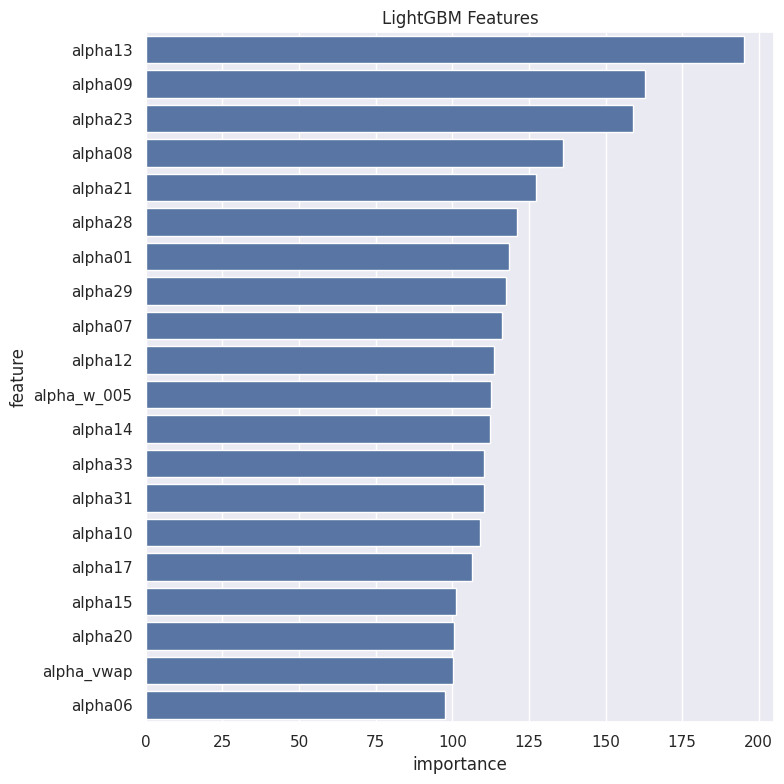

In [ ]:
def print_gbm_model_feature_importance(model):
    feature_names = features
    try:
        importances = list(model.feature_importances_)
    except:
        importances = list(model.feature_importance())
    feature_importances = [(feature,round(importance)) for feature,importance in zip(feature_names,importances)]
    feature_importances = sorted(feature_importances,key=lambda x:x[1],reverse=True)
    #print(feature_importances)
    return feature_importances
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance_df = []
for model in modellist:
    feature_importance_df_ = print_gbm_model_feature_importance(model)
    feature_importance_df_ = pd.DataFrame(feature_importance_df_)
    feature_importance_df_.columns = ["feature", "importance"]
    feature_importance_df.append(feature_importance_df_)
feature_importance_df = pd.concat(feature_importance_df)
feature_importance_df = feature_importance_df.groupby('feature')['importance'].mean().reset_index()

sss = feature_importance_df.sort_values(by="importance", ascending=False).head(20)

plt.figure(figsize=(8,8))
sns.barplot(x="importance", y="feature",
            data=sss)
plt.title('LightGBM Features')
plt.tight_layout()

In [ ]:

test = data.copy()
test = test[test['Timestamp'] > '2018-01-01']
pred = np.zeros(test.shape[0])
for model in modellist:
    pred += model.predict(test[features])
test['pred'] = pred
date_calc = sorted(test['Timestamp'].unique())


In [ ]:
test.columns

Index(['Ticker', 'Timestamp', 'alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005', 'alpha_vwap', 'alpha33', 'alpha34',
       'Company_Name', 'GICS Sector', 'ret', 'ret1', 'ret2', 'open_up',
       'pred'],
      dtype='object')

In [ ]:
test['factor_rank'] = test.groupby(['Timestamp', 'GICS Sector']).pred.rank(pct=True,method='dense')

In [ ]:
def fun(x):
    if np.isnan(x):
        return np.nan
    else:
        return min(10,int(x*10)+1)

test['factor_rank_bin'] = test.factor_rank.apply(fun)

In [ ]:
test.factor_rank_bin.value_counts()

,count
factor_rank_bin,
10,30108
7,27213
4,26634
9,26055
5,26055
3,26055
8,25476
6,25476
2,25476


<Axes: xlabel='Timestamp'>

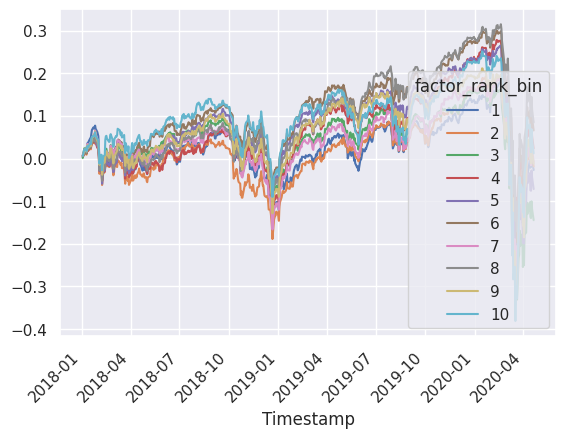

In [ ]:
(test.groupby(['factor_rank_bin', \
        'Timestamp']).ret1.mean()-1).unstack().T.cumsum().plot(rot=45,grid=True)

<Axes: xlabel='Timestamp'>

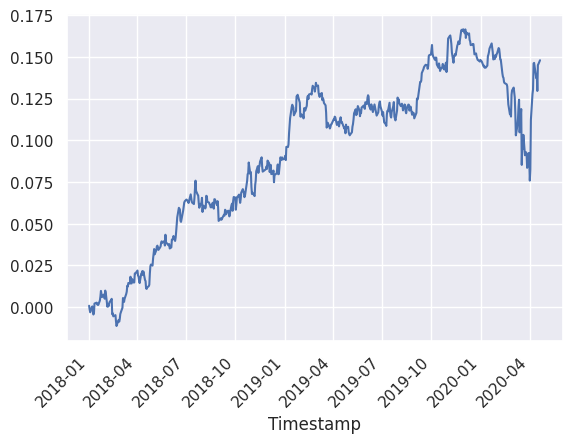

In [150]:

long_ret = (test[(test.factor_rank_bin == 6)].groupby('Timestamp').ret1.mean()-1).cumsum()
short_ret = (test[(test.factor_rank_bin == 2)].groupby('Timestamp').ret1.mean()-1).cumsum()
(long_ret - short_ret).plot(rot=45,grid=True)

In [ ]:
ret_PD = (test.groupby(['factor_rank_bin', 'Timestamp']).ret1.mean()-1.00).unstack().T

if ret_PD[1].mean()>ret_PD[10].mean():
    ret_PD['diff'] = ret_PD[1] - ret_PD[10]
else:
    ret_PD['diff'] = ret_PD[10] - ret_PD[1]


In [ ]:

def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = returns.index[dd.argmin()]
    start = returns.index[r.loc[:end].argmax()]
    return mdd, start, end





def calc_pfmc(ret_PD):
    performance = []
    for i in [1,2,3,4,5,6,7,8,9,10,'diff']:
        returnlist = ret_PD[i]
        ret_year = (returnlist.mean()-0)*252
        ret_sharpe = (returnlist.mean()-0)/returnlist.std()*(252**0.5)
        max_draw, start, end = max_dd(returnlist)
        winratio = (returnlist>0).sum()/len(returnlist)
        std = returnlist.std()
        performance.append([i,ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    return performance

calc_pfmc(ret_PD)

,group_name,return,sharpe,std,winratio,mdd
0,1,-0.011724,-0.047582,0.015521,0.554404,-0.352396
1,2,-0.008029,-0.034360,0.014719,0.528497,-0.326606
2,3,-0.062984,-0.256079,0.015494,0.523316,-0.427586
3,4,0.010357,0.041412,0.015755,0.545769,-0.353515
4,5,-0.031208,-0.119143,0.016500,0.552677,-0.437545
5,6,0.028749,0.110667,0.016365,0.547496,-0.381839
6,7,-0.003287,-0.012167,0.017018,0.549223,-0.394638
7,8,0.036838,0.133955,0.017324,0.557858,-0.369139
8,9,-0.005120,-0.017929,0.017990,0.542314,-0.446100
9,10,0.005360,0.016752,0.020155,0.516408,-0.505269


/tmp/ipython-input-3444093003.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = tmp.groupby('Timestamp').apply(lambda x: x.sort_values('pred', ascending = False).head(num)).reset_index(drop=True)


<Axes: title={'center': '2018-202 year'}, xlabel='Timestamp'>

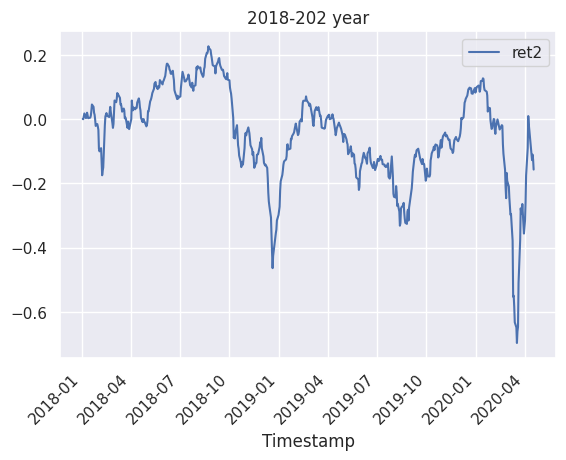

In [ ]:

tmp = test.copy()
tmp = tmp[(tmp.open_up<1.05)&(tmp.open_up>0.95)]
num = 10
tmp = tmp.groupby('Timestamp').apply(lambda x: x.sort_values('pred', ascending = False).head(num)).reset_index(drop=True)
ret_pd1 = pd.DataFrame(tmp.groupby('Timestamp').ret2.mean() - 1.0005)
(ret_pd1.loc['2018-01-01':,] ).cumsum().plot(rot=45, title = '2018-202 year')


In [ ]:
def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min().values[0]
    end = returns.index[dd.values.argmin()]
    start = returns.index[r.loc[:end].values.argmax()]
    return mdd, start, end


def calc_pfmc(ret_PD):
    ret_PD_ = ret_PD.copy()
    performance = []
    ret_PD_.columns = ['ret']
    returnlist = ret_PD_['ret']
    ret_year = (returnlist.mean())*252
    ret_sharpe = (returnlist.mean())/returnlist.std()*((252)**0.5)

    winratio = (returnlist>0).sum()/(returnlist!=0).sum()
    std = returnlist.std()

    ret2_len = pd.DataFrame(tmp.groupby('Timestamp').ret.count())
    ret2_len = ret2_len.reindex(date_calc).fillna(0)
    stock_pct = ret2_len.mean().values[0]
    max_draw, start, end = max_dd(ret_PD)
    performance.append(['LGB',ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])



    return performance

In [ ]:
calc_pfmc(ret_pd1)

,group_name,return,sharpe,std,winratio,mdd
0,LGB,-0.068489,-0.173645,0.024846,0.483592,-0.753719


#### MLP

In [ ]:
train.head()

,Ticker,Timestamp,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha_vwap,alpha33,alpha34,Company_Name,GICS Sector,ret,ret1,ret2,open_up,ret_rank
0,ACGL,2013-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.666292e+06,0.220986,NaN,arch capital group ltd,Financials,0.984112,0.997908,0.984112,NaN,0.464789
1,ACGL,2013-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.662806e+06,1.754945,NaN,arch capital group ltd,Financials,0.983856,0.991803,0.983856,1.004575,0.316901
2,ACGL,2013-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.649176e+06,1.982929,NaN,arch capital group ltd,Financials,0.990031,0.995580,0.990031,1.016145,0.232394
3,ACGL,2013-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.641886e+06,0.220986,NaN,arch capital group ltd,Financials,1.007178,0.996911,1.007178,1.016409,0.239437
4,ACGL,2013-04-05,NaN,0.000497,NaN,NaN,NaN,NaN,NaN,NaN,...,1.636814e+06,0.856144,NaN,arch capital group ltd,Financials,1.003883,1.005422,1.003883,1.010070,0.295775


In [ ]:
from numpy.random import seed
# seed(42)
seed(774)
import tensorflow as tf
# tf.random.set_seed(42)
tf.random.set_seed(774)
from tensorflow import keras
import numpy as np
from keras import backend as K

!pip install tf.keras.activations

ERROR: Could not find a version that satisfies the requirement tf.keras.activations (from versions: none)
ERROR: No matching distribution found for tf.keras.activations


In [ ]:
hidden_units = (128, 64, 32)

def base_model():
  num_input = keras.Input(shape=(len(features),), name='num_data')

  out = num_input
  for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

  out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

  model = keras.Model(inputs=[num_input], outputs=[out])
  model.compile(
      optimizer=tf.optimizers.Adam(learning_rate=0.001),
      loss='mean_squared_error',
      metrics=['mean_squared_error']
  )
  return model

In [ ]:
model = base_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ num_data (InputLayer)           │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,081 (55.00 KB)

 Trainable params: 14,081 (55.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
total_inf = np.isinf(train.select_dtypes(include=[np.number]).values).sum()
total_inf

np.int64(0)

In [ ]:
train.replace([np.inf, -np.inf], np.nan,inplace=True)
train[features] = train[features].fillna(train[features].mean())
test = data.copy()
test = test[test['Timestamp'] > '2018-01-01']
test.replace([np.inf, -np.inf], np.nan,inplace=True)
test[features] = test[features].fillna(train[features].mean())


In [ ]:
from sklearn.preprocessing import QuantileTransformer

train_nn = train[features].copy()
test_nn = test[features].copy()
qt_train = []

for col in features:
  qt = QuantileTransformer(n_quantiles=100, random_state=42, output_distribution='normal')
  train_nn[col] = qt.fit_transform(train_nn[col].values.reshape(-1,1))
  test_nn[col] = qt.transform(test_nn[col].values.reshape(-1,1))
  qt_train.append(qt)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    # min_delta=0,
    patience=10,
    verbose=1,
    mode='auto',
    # baseline=None,
    restore_best_weights=True
)
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    mode='auto',
    # min_delta=0.0001,
    # cooldown=0,
    # min_lr=0
)


In [117]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

modellist = []
y = train['ret_rank']

oof_predictions = np.zeros(train.shape[0])

for fold, (train_idx, val_idx) in enumerate(enumsplit):
  print('Fold {}'.format(fold + 1))
  X_train, X_val = train_nn.iloc[train_idx], train_nn.iloc[val_idx][features]
  y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

  model = base_model()

  model.fit(
      X_train,
      y_train,
      batch_size=256,
      epochs=100,
      verbose=1,
      validation_data=(X_val, y_val),
      callbacks=[es, plateau],
      shuffle=True,
      # verbose=1
  )
  oof_predictions[val_idx] = model.predict(X_val).reshape(1,-1)[0]
  modellist.append(model)
  print(f"Fold {fold + 1} | RMSPE: {mean_squared_error(y_val, oof_predictions[val_idx])**0.5}")
  corr_score = np.corrcoef(y_val, oof_predictions[val_idx])[0][1]
  print(f"Fold {fold + 1} | corr: {corr_score}")

rmspe_score = mean_squared_error(y, oof_predictions)**0.5
print(f"Overall RMSPE: {rmspe_score}")
corr_score = np.corrcoef(y, oof_predictions)[0][1]
print(f"Overall corr: {corr_score}")


Fold 1
Epoch 1/100
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0913 - mean_squared_error: 0.0913 - val_loss: 0.0833 - val_mean_squared_error: 0.0833 - learning_rate: 0.0010
Epoch 2/100
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0834 - mean_squared_error: 0.0834 - val_loss: 0.0834 - val_mean_squared_error: 0.0834 - learning_rate: 0.0010
Epoch 3/100
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 0.0833 - mean_squared_error: 0.0833 - val_loss: 0.0833 - val_mean_squared_error: 0.0833 - learning_rate: 0.0010
Epoch 4/100
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0833 - mean_squared_error: 0.0833 - val_loss: 0.0833 - val_mean_squared_error: 0.0833 - learning_rate: 0.0010
Epoch 5/100
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0833 - mean_squared_error: 0.0833 - val_loss: 0.0832 - val_mean_squared_error: 0.0832 - learning_rate: 0.0010
Epoch 6/100
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0833 - mean_squared_error: 0.0833 - val_loss: 0.08

In [118]:
pred = np.zeros(test.shape[0])
for model in modellist:
    pred += model.predict(test_nn[features]).reshape(1,-1)[0]
test['pred'] = pred
date_calc = sorted(test['Timestamp'].unique())

8197/8197 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
8197/8197 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
8197/8197 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
8197/8197 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
8197/8197 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
8197/8197 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
8197/8197 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
8197/8197 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
8197/8197 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
8197/8197 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


In [122]:
df.head()

,Timestamp,Ticker,ISIN,Company_Name,GICS Sector,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,...,High,Low,Open,Volume,Amount,Price_change,open_up,ret1,ret2,ret
0,2013-04-01,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,16.998896,16.532956,16.704118,1390500,2.316978e+07,-0.209234,NaN,0.997908,0.984112,0.984112
1,2013-04-02,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,4.885057,0.553236,-0.974007,...,16.764340,16.583670,16.758001,1300200,2.161979e+07,-0.819683,1.004575,0.991803,0.983856,0.983856
2,2013-04-03,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,5.569007,0.553236,-0.974007,...,16.735814,16.463223,16.688268,1402200,2.312473e+07,-0.442044,1.016145,0.995580,0.990031,0.990031
3,2013-04-04,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,16.555144,16.364963,16.532957,2694000,4.423238e+07,-0.308880,1.016409,0.996911,1.007178,1.007178
4,2013-04-05,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,2.188655,0.553236,-0.974007,...,16.447376,16.235008,16.339606,1557000,2.548518e+07,0.542217,1.010070,1.005422,1.003883,1.003883


In [123]:
test.head()

,Ticker,Timestamp,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,GICS Sector_y,ret_y,ret1_y,ret2_y,open_up_y,Company_Name,ret,ret1,ret2,open_up
0,ACGL,2018-01-02,-0.000008,0.000333,-3.244575e-07,-9.547388e-08,-0.000057,0.000120,0.000025,0.000084,...,Financials,1.003507,1.000906,1.003507,1.030464,arch capital group ltd,1.003507,1.000906,1.003507,1.030464
1,ACGL,2018-01-03,-0.000008,0.000347,-2.008075e-06,-8.253627e-08,-0.000069,0.000104,0.000021,0.000073,...,Financials,0.999661,1.003734,0.999661,1.032021,arch capital group ltd,0.999661,1.003734,0.999661,1.032021
2,ACGL,2018-01-04,-0.000005,0.000392,-3.253231e-06,-8.438338e-08,-0.000071,0.000106,0.000022,0.000075,...,Financials,0.993033,0.996055,0.993033,0.996506,arch capital group ltd,0.993033,0.996055,0.993033,0.996506
3,ACGL,2018-01-05,-0.000005,0.000439,-4.275885e-06,-8.942320e-08,-0.000075,0.000113,0.000023,0.000079,...,Financials,0.986653,1.000113,0.986653,1.000339,arch capital group ltd,0.986653,1.000113,0.986653,1.000339
4,ACGL,2018-01-08,-0.000005,0.000433,-4.430855e-06,-8.615657e-08,-0.000073,0.000109,0.000022,0.000076,...,Financials,0.983449,0.987100,0.983449,1.007016,arch capital group ltd,0.983449,0.987100,0.983449,1.007016


In [127]:
test.columns

Index(['Ticker', 'Timestamp', 'alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005', 'alpha_vwap', 'alpha33', 'alpha34',
       'Company_Name_x', 'GICS Sector_x', 'ret_x', 'ret1_x', 'ret2_x',
       'open_up_x', 'pred', 'Company_Name_y', 'GICS Sector_y', 'ret_y',
       'ret1_y', 'ret2_y', 'open_up_y', 'Company_Name', 'ret', 'ret1', 'ret2',
       'open_up'],
      dtype='object')

In [125]:
df.head()

,Timestamp,Ticker,ISIN,Company_Name,GICS Sector,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,...,High,Low,Open,Volume,Amount,Price_change,open_up,ret1,ret2,ret
0,2013-04-01,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,16.998896,16.532956,16.704118,1390500,2.316978e+07,-0.209234,NaN,0.997908,0.984112,0.984112
1,2013-04-02,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,4.885057,0.553236,-0.974007,...,16.764340,16.583670,16.758001,1300200,2.161979e+07,-0.819683,1.004575,0.991803,0.983856,0.983856
2,2013-04-03,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,5.569007,0.553236,-0.974007,...,16.735814,16.463223,16.688268,1402200,2.312473e+07,-0.442044,1.016145,0.995580,0.990031,0.990031
3,2013-04-04,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,-0.391764,0.553236,-0.974007,...,16.555144,16.364963,16.532957,2694000,4.423238e+07,-0.308880,1.016409,0.996911,1.007178,1.007178
4,2013-04-05,ACGL,BMG0450A1053,arch capital group ltd,Financials,-0.426378,-0.44602,2.188655,0.553236,-0.974007,...,16.447376,16.235008,16.339606,1557000,2.548518e+07,0.542217,1.010070,1.005422,1.003883,1.003883


In [130]:
# test = pd.merge(test, df[['Timestamp', 'Ticker', 'Company_Name','GICS Sector', 'ret', 'ret1', 'ret2', 'open_up']], how='left', on=['Timestamp', 'Ticker'])
test['factor_rank'] = test.groupby(['Timestamp','GICS Sector_y']).pred.rank(pct=True,method='dense')

def fun(x):
  if np.isnan(x):
    return np.nan
  else:
    return min(10, int(x*10)+1)

test['factor_rank_bin'] = test.factor_rank.apply(fun)
test.factor_rank_bin.value_counts()

,count
factor_rank_bin,
10,30108
7,27213
4,26634
3,26055
9,26055
5,26055
8,25476
6,25476
2,25476


<Axes: xlabel='Timestamp'>

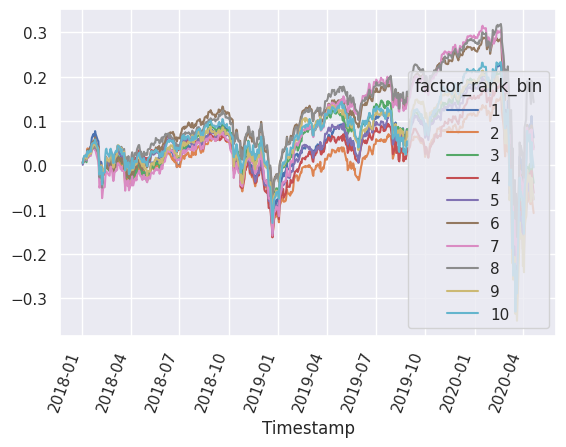

In [134]:
(test.groupby(['factor_rank_bin', \
        'Timestamp']).ret1.mean()-1).unstack().T.cumsum().plot(rot=70,grid=True)

<Axes: xlabel='Timestamp'>

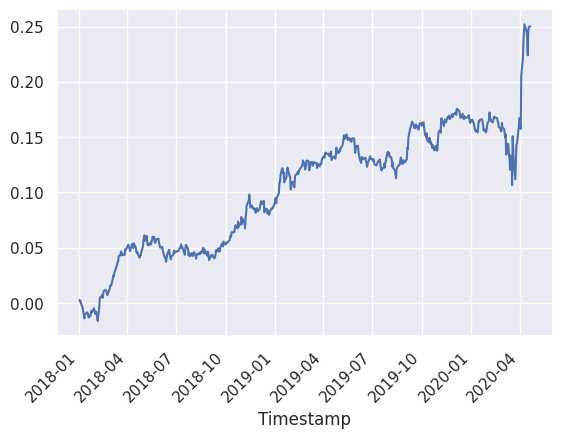

In [149]:
long_ret = (test[(test.factor_rank_bin == 8)].groupby('Timestamp').ret1.mean()-1).cumsum()
short_ret = (test[(test.factor_rank_bin == 2)].groupby('Timestamp').ret1.mean()-1).cumsum()
(long_ret - short_ret).plot(rot=45,grid=True)

In [138]:
ret_PD = (test.groupby(['factor_rank_bin', 'Timestamp']).ret1.mean()-1.00).unstack().T

if ret_PD[1].mean()>ret_PD[10].mean():
    ret_PD['diff'] = ret_PD[1] - ret_PD[10]
else:
    ret_PD['diff'] = ret_PD[10] - ret_PD[1]


In [139]:

def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = returns.index[dd.argmin()]
    start = returns.index[r.loc[:end].argmax()]
    return mdd, start, end





def calc_pfmc(ret_PD):
    performance = []
    for i in [1,2,3,4,5,6,7,8,9,10,'diff']:
        returnlist = ret_PD[i]
        ret_year = (returnlist.mean()-0)*252
        ret_sharpe = (returnlist.mean()-0)/returnlist.std()*(252**0.5)
        max_draw, start, end = max_dd(returnlist)
        winratio = (returnlist>0).sum()/len(returnlist)
        std = returnlist.std()
        performance.append([i,ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    return performance

calc_pfmc(ret_PD)

,group_name,return,sharpe,std,winratio,mdd
0,1,0.027471,0.113465,0.015252,0.550950,-0.336964
1,2,-0.046929,-0.190248,0.015539,0.550950,-0.384115
2,3,-0.017214,-0.070470,0.015388,0.535406,-0.380153
3,4,-0.027003,-0.107029,0.015893,0.544041,-0.390841
4,5,-0.033461,-0.130097,0.016202,0.547496,-0.414359
5,6,0.017581,0.066783,0.016583,0.550950,-0.369145
6,7,0.015813,0.057857,0.017217,0.535406,-0.408974
7,8,0.062173,0.225954,0.017333,0.542314,-0.364377
8,9,-0.033487,-0.115392,0.018281,0.531952,-0.464695
9,10,-0.001939,-0.006499,0.018791,0.516408,-0.456613


In [141]:
test.head()

,Ticker,Timestamp,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,ret1_y,ret2_y,open_up_y,Company_Name,ret,ret1,ret2,open_up,factor_rank,factor_rank_bin
0,ACGL,2018-01-02,-0.000008,0.000333,-3.244575e-07,-9.547388e-08,-0.000057,0.000120,0.000025,0.000084,...,1.000906,1.003507,1.030464,arch capital group ltd,1.003507,1.000906,1.003507,1.030464,0.682540,7
1,ACGL,2018-01-03,-0.000008,0.000347,-2.008075e-06,-8.253627e-08,-0.000069,0.000104,0.000021,0.000073,...,1.003734,0.999661,1.032021,arch capital group ltd,0.999661,1.003734,0.999661,1.032021,0.793651,8
2,ACGL,2018-01-04,-0.000005,0.000392,-3.253231e-06,-8.438338e-08,-0.000071,0.000106,0.000022,0.000075,...,0.996055,0.993033,0.996506,arch capital group ltd,0.993033,0.996055,0.993033,0.996506,0.888889,9
3,ACGL,2018-01-05,-0.000005,0.000439,-4.275885e-06,-8.942320e-08,-0.000075,0.000113,0.000023,0.000079,...,1.000113,0.986653,1.000339,arch capital group ltd,0.986653,1.000113,0.986653,1.000339,0.825397,9
4,ACGL,2018-01-08,-0.000005,0.000433,-4.430855e-06,-8.615657e-08,-0.000073,0.000109,0.000022,0.000076,...,0.987100,0.983449,1.007016,arch capital group ltd,0.983449,0.987100,0.983449,1.007016,0.793651,8


/tmp/ipython-input-2850261884.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = tmp.groupby('Timestamp').apply(lambda x: x.sort_values('factor_rank', ascending = False).head(num)).reset_index(drop=True)


<Axes: title={'center': '2018-2020 year'}, xlabel='Timestamp'>

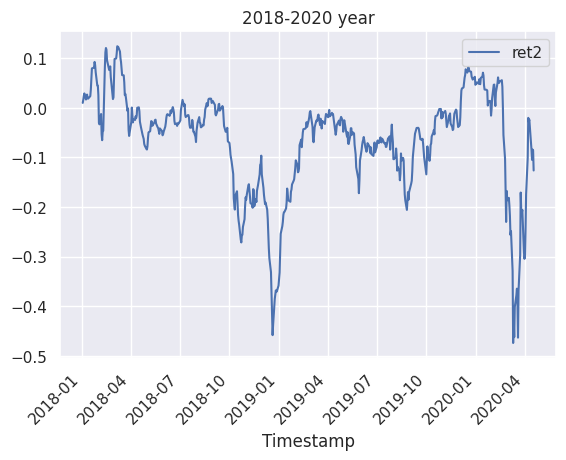

In [142]:
tmp = test.copy()
# tmp = tmp[~tmp.close.isna()].reset_index(drop=True)
tmp = tmp[(tmp.open_up<1.05)&(tmp.open_up>0.95)]
num = 10
tmp = tmp.groupby('Timestamp').apply(lambda x: x.sort_values('factor_rank', ascending = False).head(num)).reset_index(drop=True)
ret_pd1 = pd.DataFrame(tmp.groupby('Timestamp').ret2.mean() - 1.0005)
(ret_pd1.loc['2018-01-01':,] ).cumsum().plot(rot=45, title = '2018-2020 year')

In [147]:
def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min().values[0]
    end = returns.index[dd.values.argmin()]
    start = returns.index[r.loc[:end].values.argmax()]
    return mdd, start, end


def calc_pfmc(ret_PD):
    ret_PD_ = ret_PD.copy()
    performance = []
    ret_PD_.columns = ['ret']
    returnlist = ret_PD_['ret']
    ret_year = (returnlist.mean())*252
    ret_sharpe = (returnlist.mean())/returnlist.std()*((252)**0.5)

    winratio = (returnlist>0).sum()/(returnlist!=0).sum()
    std = returnlist.std()

    ret2_len = pd.DataFrame(tmp.groupby('Timestamp').ret.count())
    ret2_len = ret2_len.reindex(date_calc).fillna(0)
    stock_pct = ret2_len.mean().values[0]
    max_draw, start, end = max_dd(ret_PD)
    performance.append(['LGB',ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])



    return performance

In [148]:
calc_pfmc(ret_pd1)

,group_name,return,sharpe,std,winratio,mdd
0,LGB,-0.05516,-0.161526,0.021512,0.516408,-0.532686
